In [1]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

words = open('names.txt','r').read().splitlines()

In [2]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [3]:
import random
random.seed(42)
random.shuffle(words)

In [4]:
block_size = 8

def build_dataset(words):    
    X,Y = [],[]
    for w in words:
        #print(w)
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context)+ '-->' + ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [15]:
class linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_out**0.5
        self.bias = torch.zeros(fan_out)if bias else None

    def __call__(self, X):
        self.out = X@self.weight
        if self.bias is not None:
            self.out+=self.bias
        
        #print('Linear :',self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.weight] + ([]if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps = 1e-5,momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, X):
        if self.training:
            if X.ndim ==2:
                dim = 0
            elif X.ndim ==3:
                dim = (0,1)
            xmean = X.mean(dim,keepdim=True)
            xvar = X.var(dim,keepdim = True)

        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (X-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean =  (1-self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var =  (1-self.momentum) * self.running_var + self.momentum*xvar

        #print("BatchNorm1D :",self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.gamma,self.beta]
    

class Tanh:
    def __call__(self, X):
        self.out = torch.tanh(X)
        #print("Tanh :",self.out.shape)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self,num_embedding,embedding_dim):
        self.weight = torch.randn((num_embedding,embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        #print("Embedding :",self.out.shape)
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class Flatten:
    def __init__(self,n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B,-1,C*self.n)

        if x.shape[1]==1:
            x = x.squeeze(1)

        self.out = x
        #print("Flatten :",self.out.shape)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self,layers):
        self.layers=layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        #print("Sequential :",self.out.shape)
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [16]:
torch.manual_seed(42)

In [17]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(2),linear(n_embd*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Flatten(2),linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Flatten(2),linear(n_hidden*2,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    linear(n_hidden,vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *=0.1

parameters = model.parameters()

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    logits = model(Xb)

    loss = F.cross_entropy(logits,Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    if i%10000==0:
        print(f"{i:7d}/{max_steps:7d}  : {loss.item() : 4f}")
    
    lossi.append(loss.item())

      0/ 200000  :  3.325642
  10000/ 200000  :  2.328538
  20000/ 200000  :  2.203945
  30000/ 200000  :  1.728122
  40000/ 200000  :  1.949417
  50000/ 200000  :  2.171740
  60000/ 200000  :  1.849526
  70000/ 200000  :  2.360723
  80000/ 200000  :  2.445001
  90000/ 200000  :  2.397704
 100000/ 200000  :  2.034242
 110000/ 200000  :  2.383547
 120000/ 200000  :  2.217050
 130000/ 200000  :  1.806733
 140000/ 200000  :  1.892498
 150000/ 200000  :  2.175140
 160000/ 200000  :  1.695331
 170000/ 200000  :  2.424170
 180000/ 200000  :  1.749880
 190000/ 200000  :  2.141664


In [20]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 10)
Flatten : (32, 4, 20)
linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
Flatten : (32, 2, 136)
linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
Flatten : (32, 136)
linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
linear : (32, 27)


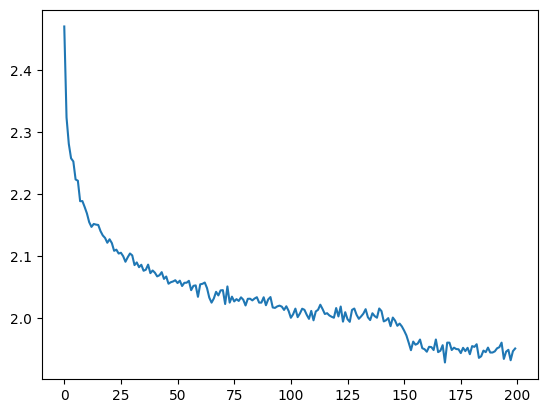

In [22]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [23]:
for layer in model.layers:
    layer.training = False

In [24]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val' : (Xdev,Ydev),
        'test' : (Xte,Yte)
    }[split]
    
    logits = model(Xb)

    loss = F.cross_entropy(logits,Yb)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 1.918786644935608
val 1.918786644935608


In [25]:
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break


    print(''.join(itos[i] for i in out))



kamoni.
lihact.
stentar.
jasla.
anneli.
faynley.
matharyn.
rhylan.
akshas.
shirah.
tajus.
raphte.
marsanta.
mckintallo.
luxahn.
marykah.
zergw.
cordo.
aleena.
marhe.
